# Music Generator
## COMP 432 Fall 2020
## Natalia Whiteley 40044353
## Michael Naccache 29794840

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from music21 import *
import tensorflow as tf

In [26]:
VERBOSE = True
GENRES = ['sample', 'classical', ' blues', 'poprock', 'original', 'jazz', 'country', 'zelda']
TRAIN_GENRE = 'zelda'
PALETTE = 'husl'
TIMESTEPS = 32
CHECKPOINT_PATH = 'trained_models/'
SONG_LENGTH = 100

## Part 1: Import Dataset

Here we define some helper functions for loading files and parsing the midi format. Then, we load the midi files and thier genres.
The format we use to import the midi files is a list of every song, where each song is a dictionary of a track for each instrument. Each instrument track is a list of all the notes in the track.

ex. all_songs -> jazz_song_1 -> piano track -> A5, G2, B5, ...

In [30]:
# given the name of a midi file, returns a 2D array of notes per instrument
def import_midi(midi_file, verbose=VERBOSE):

    # parse midi file
    midi = converter.parse(midi_file)
  
    # seperate based on instrument
    midi_parts = instrument.partitionByInstrument(midi)

    notes = {}
    notes_to_parse = []

    for part in midi_parts.parts:
        notes[part.getInstrument().__class__] = []
        notes_to_parse = part.recurse()

        # finding whether a particular element is note or a chord
        for element in notes_to_parse: 
            #note
            if isinstance(element, note.Note):
                notes[part.getInstrument().__class__].append(str(element.pitch))
            
            #chord
            elif isinstance(element, chord.Chord):
                notes[part.getInstrument().__class__].append('.'.join(str(n.pitch) for n in element))

    # remove any empty instruments
    notes = {k: np.array(v) for k, v in notes.items() if v}

    if verbose:
        print('Finished importing {}.'.format(midi_file))

    return notes

# gets the path and label for every file in a directory and its sub-directories
def get_all_files_in_dir(dir_path, verbose=VERBOSE):
    midis = []
    genres = []

    for root, dirs, files in os.walk(dir_path):
        genre = os.path.basename(root)

        # if genre not in list, ignore it
        if genre in GENRES:
            # load all midi files in this directory
            for file in files:
                if file.endswith('.mid'):
                    midis.append(os.path.join(root, file))
                    genres.append(genre)
            
            if verbose:
                print('Loaded all {} midi files.'.format(genre))

    return midis, genres


In [36]:
midi_filenames, genres = get_all_files_in_dir('./midi_files')
songs = [import_midi(x) for x in midi_filenames if genres[midi_filenames.index(x)] == TRAIN_GENRE]
# some video game songs have unknown instruments
songs = [song for song in songs if song != {}]

Loaded all zelda midi files.
Loaded all original midi files.
Loaded all poprock midi files.
Loaded all classical midi files.
Loaded all sample midi files.
Loaded all country midi files.
Loaded all jazz midi files.
Finished importing ./midi_files/zelda/The Legend of Zelda Majoras Mask - Title Screen.mid.
Finished importing ./midi_files/zelda/The Legend of Zelda - Title.mid.
Finished importing ./midi_files/zelda/The Legend of Zelda Twilight Princess - Orchestra Piece 1.mid.
Finished importing ./midi_files/zelda/Zelda - Legend of Zelda - Ganon's Theme.mid.
Finished importing ./midi_files/zelda/The Legend of Zelda - Death Mountain.mid.
Finished importing ./midi_files/zelda/Legend_of_Zelda_A_Link_Between_Worlds_-_File_Select.mid.
Finished importing ./midi_files/zelda/The Legend of Zelda Ocarina of Time - Song of Storms.mid.
Finished importing ./midi_files/zelda/Zelda - Legend of Zelda - Dungeon Music.mid.
Finished importing ./midi_files/zelda/The Legend of Zelda The Wind Waker - Title Scree

## Part 2: Data Analysis
Here we make some graphs for the distribution of genres and distributions of notes in each song to see what adjustements we need to make to the data.

From the genre distribution, jazz leads by a significant margin, meaning it would get the best results from training.

Text(0.5, 1.0, 'Genre Distribution in Complete Dataset')

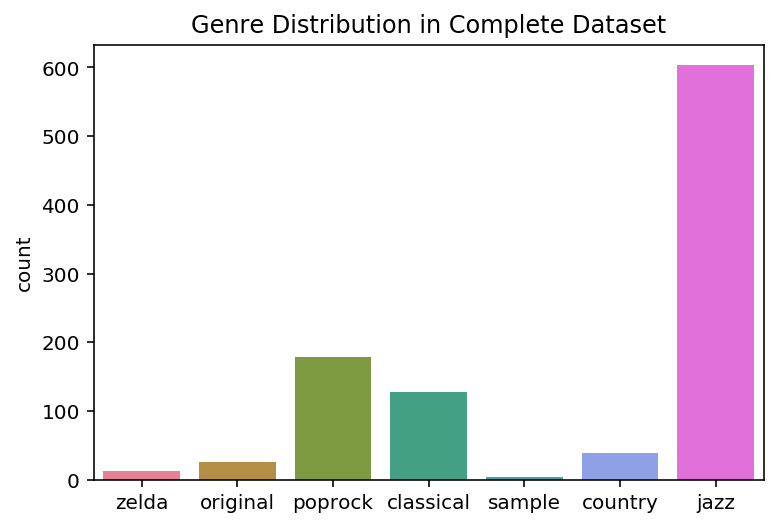

In [40]:
# graph distribution of genres
sns.countplot(genres, palette=PALETTE)
plt.title('Genre Distribution in Complete Dataset')

Text(0.5, 1.0, 'Instrument Distribution in Training Set')

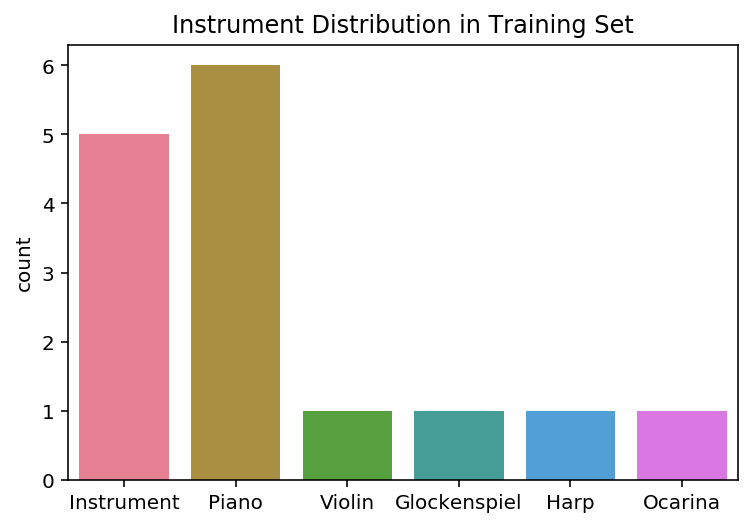

In [46]:
# graph instrument distribution in training data
instruments = []
for song in songs:
    for instrument in song.keys():
        instruments.append(str(instrument).split('.')[2][:-2])

sns.countplot(instruments, palette=PALETTE)
plt.title('Instrument Distribution in Training Set')

In [48]:
# graph note distribution in one song
def plot_notes_per_instrument(song, song_name):
    fig, ax = plt.subplots(len(song.keys()), 1, figsize=(10, 5))
    fig.suptitle('Note distribution in by instrument {}'.format(song_name))
    
    for instrument in song.keys():        
        if len(song.keys()) == 1:
            sns.countplot(song[instrument], ax=ax, palette=PALETTE)
            ax.set_title(str(instrument).split('.')[2][:-2])
            ax.tick_params(axis='x', labelsize=5, labelrotation=45)
        else:
            i = 0  
            sns.countplot(song[instrument], ax=ax[i], palette=PALETTE)
            ax[i].set_title(str(instrument).split('.')[2][:-2])
            ax[i].tick_params(axis='x', labelsize=5, labelrotation=45)
            i += 1

With the note distributions, you can see that some instruments have an excess of notes played only a few times that don't add much to the general composition.

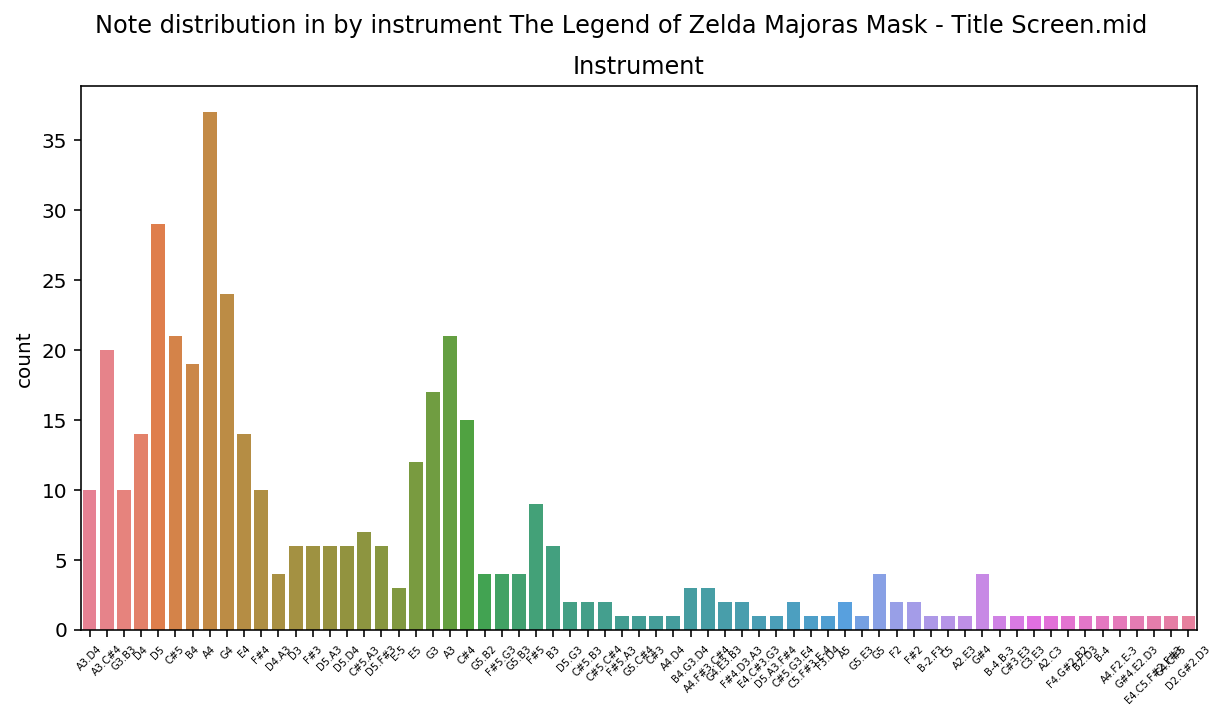

In [49]:
plot_notes_per_instrument(songs[0], os.path.basename(midi_filenames[0]))

## Part 3: Split and Normalize Dataset

In [50]:
# remove any unfrequent notes; ie. less than 10% of the max frequency
def remove_unfrequent_notes(song):
    # select each instrument track
    for instrument in song.keys():
        freq = Counter(song[instrument])

        # get the max feuquency of notes
        max_freq = freq.most_common(1)[0][1]

        # make list of all the significant notes
        frequent_notes = [note for note in song[instrument] if freq[note] >= max_freq * 0.05]
        new_song = []
        for note in song[instrument]:
            if note in frequent_notes:
                new_song.append(note)
        
        song[instrument] = new_song

    return song

# remove infrequent notes from songs
songs = [remove_unfrequent_notes(song) for song in songs]

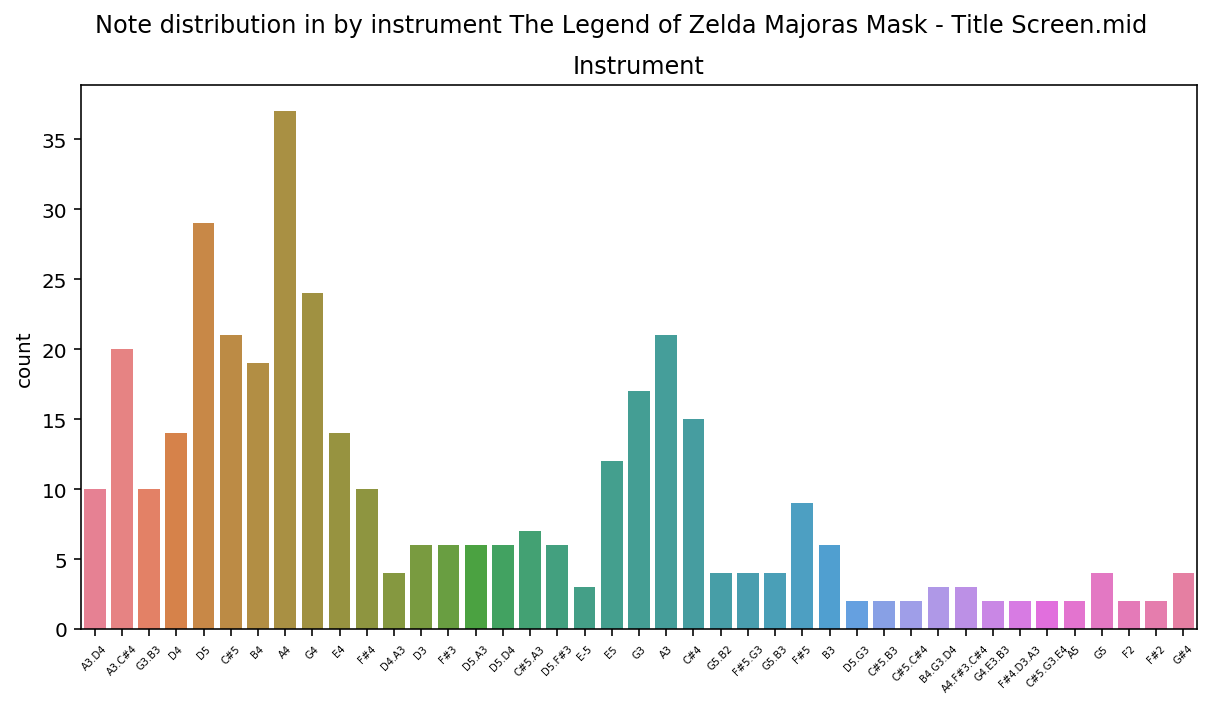

In [51]:
# regraph normalized notes
plot_notes_per_instrument(songs[0], os.path.basename(midi_filenames[0]))

Create the X and y datasets. As this model is trying to predict the next note given a sequence of previous notes, X will be a slice of notes and y is the next note after the slice.

ex. song = [C3, D3, E3, C3] -> X = [C3, D3, E3] y = [C3]

In [52]:
# dictionaries to quickly convert between notes and ints and vice versa
note_to_int = {}
int_to_note = {}

def convert_song(song, reverse=False):
    new_song = []

    # reverse is translating ints back to note strings
    if reverse:
        for note in song:
            new_song.append(int_to_note[note])

    # translate note strings to ints
    else:
        for note in song:
            # note already in dictionary
            if note in note_to_int:
                new_song.append(note_to_int[note])
            # add note to both dictionaries
            else:
                note_to_int[note] = len(note_to_int)
                int_to_note[note_to_int[note]] = note
                new_song.append(note_to_int[note])

    return new_song

In [53]:
def combine_notes(combine_songs):
    long_song = {}
    for song in combine_songs:
        for instrument in song.keys():
            if instrument in long_song.keys():
                long_song[instrument] += song[instrument]
            else:
                long_song[instrument] = song[instrument]
        
    return long_song

In [54]:
def make_X_and_y(notes):
    X = []
    y = []

    for note in notes:
        for i in range(0, len(notes) - TIMESTEPS, 1):
            notes_in = notes[i:i + TIMESTEPS]
            notes_out = notes[i + TIMESTEPS]
            
            X.append(notes_in)
            y.append(notes_out)

    return X, y

def get_train_and_val(X, y):
    # create X and y from int-encoded categories
    X = np.array(X)
    y = np.array(y)

    # split into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # convert train and val sets to tensors
    X_train = tf.convert_to_tensor(X_train)
    X_val = tf.convert_to_tensor(X_val)
    y_train = tf.convert_to_tensor(y_train)
    y_val = tf.convert_to_tensor(y_val)

    return X_train, X_val, y_train, y_val

In [55]:
X_train_all_instruments, X_val_all_instruments, y_train_all_instruments, y_val_all_instruments = {}, {}, {}, {}

# flatten songs so it contains all notes from a genre
train_song = combine_notes(songs)

for instrument in train_song.keys():
    X, y = make_X_and_y(convert_song(train_song[instrument]))
    X_train, X_val, y_train, y_val = get_train_and_val(X, y)

    X_train_all_instruments[instrument] = X_train
    X_val_all_instruments[instrument] = X_val
    y_train_all_instruments[instrument] = y_train
    y_val_all_instruments[instrument] = y_val

## Part 3: Train GAN With Wavenet

In [62]:
# wavenet-ish model
model = tf.keras.Sequential([
    # embedding layer, so that similar values have similar weights
    tf.keras.layers.Embedding(len(note_to_int), 100, input_length=32 ,trainable=True),
    # step 1: causal 1D convolution layer
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='causal'),
    # step 2: dialated 1D causal convolutional layer with sigmoid activation
    tf.keras.layers.Conv1D(128, 3, activation='sigmoid', dilation_rate=2, padding='causal'),
    # step 3: dialated 2D causal convolutional layer with tanh activation
    tf.keras.layers.Conv1D(256, 3, activation='tanh', dilation_rate=4, padding='causal'),
    # i don't know what this is tbh, max of dilated values i guess
    tf.keras.layers.GlobalMaxPool1D(),
    # reduce to output size
    tf.keras.layers.Dense(len(note_to_int), activation='softmax')
])

# compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# pretty summary of our model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 100)           17500     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 64)            19264     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 32, 128)           24704     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 32, 256)           98560     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 175)               44975     
Total params: 205,003
Trainable params: 205,003
Non-trainable params: 0
________________________________________________

In [21]:
for instrument in X_train_all_instruments.keys():
    
    # load model if checkpoint exists, or train the model
    if (os.path.exists('./model_checkpoints/best_{}_model.ckpt.index'.format(str(instrument).split('.')[2][:-2]))):
        #model.load_weights('./model_checkpoints/best_{}_model.ckpt'.format(instrument))
        continue #if true go to next loop/check next instrument 
    else:
        # make callback to save best model weights
        model_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./model_checkpoints/best_{}_model.ckpt'.format(str(instrument).split('.')[2][:-2]), save_weights_only=True,
        monitor='val_loss', mode='min',save_best_only=True, verbose=1)
        model.fit(X_train_all_instruments[instrument], y_train_all_instruments[instrument], validation_data=(X_val_all_instruments[instrument], y_val_all_instruments[instrument]), epochs=5, batch_size=32, callbacks=[model_callback])
        


Epoch 1/5
91768/91770 [============================>.] - ETA: 0s - loss: 4.7756
Epoch 00001: val_loss improved from inf to 4.56000, saving model to ./model_checkpoints/best_Piano_model.ckpt
91770/91770 [==============================] - 1041s 11ms/step - loss: 4.7756 - val_loss: 4.5600
Epoch 2/5
91766/91770 [============================>.] - ETA: 0s - loss: 4.3334
Epoch 00002: val_loss improved from 4.56000 to 4.15954, saving model to ./model_checkpoints/best_Piano_model.ckpt
91770/91770 [==============================] - 1028s 11ms/step - loss: 4.3334 - val_loss: 4.1595
Epoch 3/5
91768/91770 [============================>.] - ETA: 0s - loss: 4.0431
Epoch 00003: val_loss improved from 4.15954 to 3.98339, saving model to ./model_checkpoints/best_Piano_model.ckpt
91770/91770 [==============================] - 976s 11ms/step - loss: 4.0431 - val_loss: 3.9834
Epoch 4/5
91770/91770 [==============================] - ETA: 0s - loss: 3.9658
Epoch 00004: val_loss improved from 3.98339 to 3.960

Now, we use the trained model to create new music by selecting a random starting note and have the model predict the successive notes. The model uses the first random note to start the song, then the next predictions are based on the past predictions of the model.

In [61]:
new_song = {}

for instrument in X_val_all_instruments.keys():
    # choose a random note to start the music
    index = np.random.randint(0, len(X_val_all_instruments[instrument]) - 1)
    past_notes = tf.convert_to_tensor(X_val_all_instruments[instrument][index])

    for i in range(SONG_LENGTH):
        past_notes = tf.reshape(past_notes, [TIMESTEPS])

        # get predicted note given previous notes
        model.load_weights('./model_checkpoints/best_{}_model.ckpt'.format(str(instrument).split('.')[2][:-2]))
        note_prob  = model.predict(past_notes)[0]
        next_note = np.argmax(note_prob, axis=0)

        # add predicted note to song
        if instrument in new_song.keys():
            new_song[instrument].append(next_note)
        else: new_song[instrument] = [next_note]

        # add prediction to past notes to use for next prediction
        past_notes_numpy = past_notes.numpy()
        past_notes_numpy = np.append(past_notes_numpy, next_note)
        past_notes_numpy = past_notes_numpy[1:]
        past_notes = tf.convert_to_tensor(past_notes_numpy)

new_song = {instrument: convert_song(new_song[instrument], reverse=True) for instrument in new_song.keys()}
print(new_song)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./model_checkpoints/best_Instrument_model.ckpt

In [60]:
def export_midi(song):    
    output_streams = []
    
    for instrument in song.keys():
        # get instrument type
        offset = 0
        output_notes = []

        for song_note in song[instrument]:
            midi_note = None

            # note is a chord
            if '.' in song_note:
                chord_notes = song_note.split('.')
                # make each note a music 21 note
                chord_notes = [note.Note(chord_note) for chord_note in chord_notes]
                
                # assign instrument and offset to each note
                for chord_note in chord_notes:
                    chord_note.storedInstrument = instrument
                    chord_note.offset = offset

                midi_note = chord.Chord(chord_notes)

            # note is a single note
            else:
                # convert to music 21 note
                midi_note = note.Note(name=song_note)
                # assign instrument and offset to note
                midi_note.storedInstrument = instrument
                midi_note.offset = offset

            output_notes.append(midi_note)

            offset += 1
        
        # make note track into a sub-stream
        output_streams.append(stream.Stream(output_notes))
    
    # create parent stream
    midi_stream = stream.Stream()

    # add sub streams for every instrument
    for sub_stream in output_streams:
        midi_stream.insert(0, sub_stream)

    # export final song
    midi_stream.show('text')
    midi_stream.write('midi', fp='result.mid')

export_midi(new_song)

## Part 5: Results

In [16]:
# TODO: make function that compares notes in training data with generated results

## Sources

* https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
* https://www.kaggle.com/wfaria/midi-music-data-extraction-using-music21
* https://jazz-soft.net/demo/GeneralMidi.html